# Final Resource

## Introduction

(add more later)

To predict the outcome of a given basketball game, our team is interested in comparing a team's recent performace (based on the last 8 games of the season) and current Elo score (a team a "rating"), against other team's recent performance and Elo score.  

## Set-up

In [110]:
# Set up
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
from scipy.stats import ttest_ind # t-tests
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics
matplotlib.style.use('ggplot')
%matplotlib inline

# Load the data,
cities = pd.read_csv('./ncaa-data/Cities.csv')
conf = pd.read_csv('./ncaa-data/Conferences.csv')
confGames = pd.read_csv('./ncaa-data/ConferenceTourneyGames.csv')
gameCities = pd.read_csv('./ncaa-data/GameCities.csv')
tCompRes = pd.read_csv('./ncaa-data/NCAATourneyCompactResults.csv')
tDetRes= pd.read_csv('./ncaa-data/NCAATourneyDetailedResults.csv')
tSeedRoundSlots = pd.read_csv('./ncaa-data/NCAATourneySeedRoundSlots.csv')
tSeeds = pd.read_csv('./ncaa-data/NCAATourneySeeds.csv')
tSlots = pd.read_csv('./ncaa-data/NCAATourneySlots.csv')
regCompRes = pd.read_csv('./ncaa-data/RegularSeasonCompactResults.csv')
regDetRes = pd.read_csv('./ncaa-data/RegularSeasonDetailedResults.csv')
seasons = pd.read_csv('./ncaa-data/Seasons.csv')
secTCompRes = pd.read_csv('./ncaa-data/SecondaryTourneyCompactResults.csv')
secTTeams = pd.read_csv('./ncaa-data/SecondaryTourneyTeams.csv')
teamCoaches = pd.read_csv('./ncaa-data/TeamCoaches.csv')
teamConf = pd.read_csv('./ncaa-data/TeamConferences.csv')
teams = pd.read_csv('./ncaa-data/Teams.csv')

## Exploratory Data Analysis
### Data Overview
A brief data overview of the teams, seasons, seeds, tournament and regular season compact results and detailed results. 

In [45]:
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [49]:
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [47]:
tSeeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [48]:
regCompRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [38]:
tCompRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [39]:
tDetRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,...,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,...,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,...,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,...,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,...,21,15,20,10,26,16,14,5,8,19


In [50]:
regDetRes.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [2]:
regCompRes.describe()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,150684.000000,150684.000000,150684.000000,150684.000000,150684.000000,150684.000000,150684.000000
mean,2002.127107,75.065315,1286.788737,76.673555,1282.773665,64.572848,0.045506
std,9.508740,33.383070,104.562929,12.141671,104.780202,11.376171,0.250971
min,1985.000000,0.000000,1101.000000,34.000000,1101.000000,20.000000,0.000000
25%,1994.000000,47.000000,1198.000000,68.000000,1191.000000,57.000000,0.000000
50%,2003.000000,77.000000,1284.000000,76.000000,1280.000000,64.000000,0.000000
75%,2010.000000,103.000000,1380.000000,84.000000,1375.000000,72.000000,0.000000
max,2017.000000,132.000000,1464.000000,186.000000,1464.000000,150.000000,6.000000


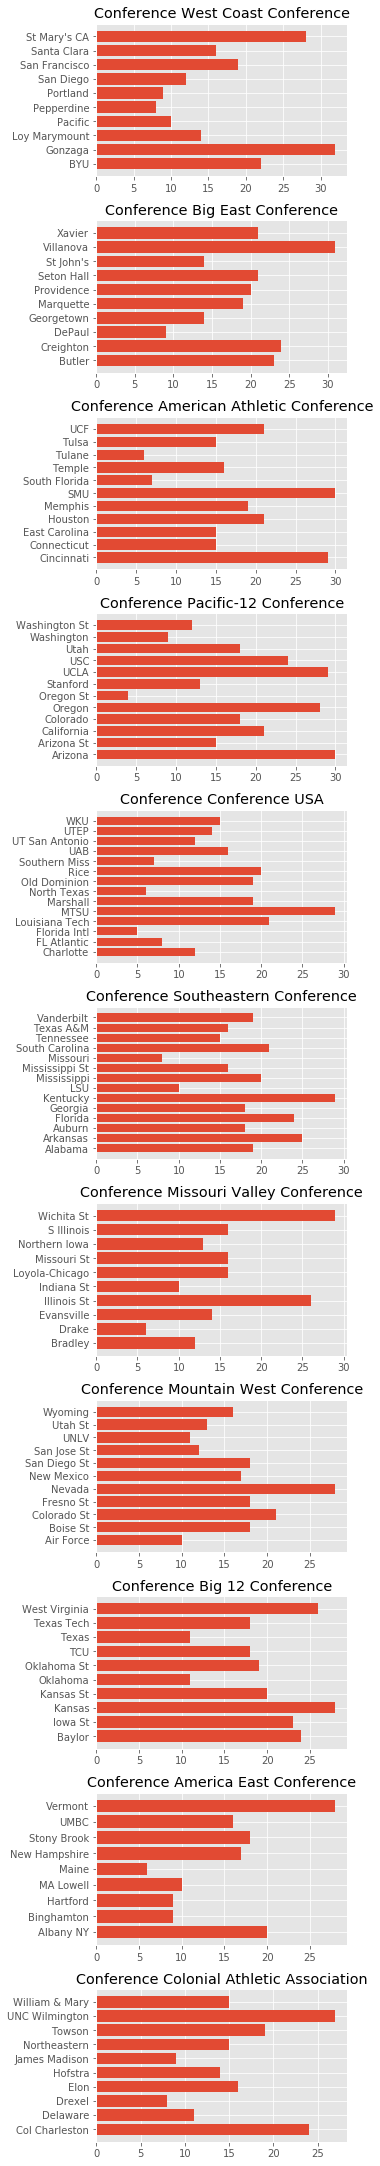

In [4]:
# Total number of wins per teamID in 2017
winsDF = regCompRes.loc[regCompRes['Season'] == 2017].groupby('WTeamID').size().to_frame().reset_index()
winsDF.columns = ["TeamID", "Wins"] # rename columns

wins_df = pd.merge(winsDF,teams,on='TeamID')
wins_df = pd.merge(wins_df, teamConf, on='TeamID')
wins_df = pd.merge(wins_df, conf, on = 'ConfAbbrev')

del wins_df['TeamID'] 
del wins_df['FirstD1Season'] 
del wins_df['LastD1Season']
del wins_df['ConfAbbrev']

wins_df = wins_df.loc[wins_df['Season'] == 2017]
wins_df= wins_df.sort_values(by=['Wins'], ascending = False)

wins_df.rename(columns={'Description':'Conference Name'}, inplace=True)


conferences = wins_df['Conference Name'].unique()
fig, axes = plt.subplots(ncols=1, nrows=11, figsize=(5,30))
for i, ax in enumerate(axes.flat):
    conf_data = wins_df.loc[wins_df['Conference Name'] == conferences[i]].dropna()
    ax.barh(conf_data['TeamName'], conf_data['Wins'])
    ax.set_title("Conference " + conferences[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

#print(wins_df)


# for conference in wins_df.Description.unique:
#      wins_df.loc[wins_df['Description'] == conference]
        
# plt.barh(wins_df['TeamName'], wins_df['Wins'])


<function matplotlib.pyplot.show>

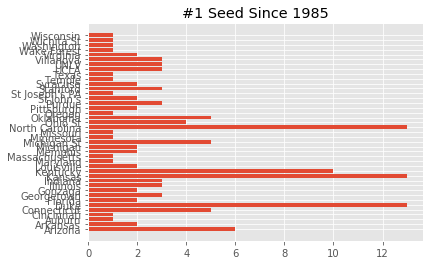

In [113]:
# Copy the original data
seed_count = tSeeds.copy(deep=True)

# Remove the region from the seed
seed_only = seed_count['Seed'].str[1:]

# Replace the old seed col with the new one without region 
seed_count['Seed'] = seed_only

# Replace all the 01 objects with an int of 1
seed_count['Seed'].replace({'01': 1}, inplace=True)

# Filter the dataframe to only show teams with #1 seed
seed_count = seed_count.loc[seed_count['Seed'] == 1]

# Count how many times a team has been #1 seed
seed_count = seed_count.groupby('TeamID').size().to_frame().reset_index()

# Replace TeamID with TeamName
seed_count = pd.merge(seed_count,teams,on='TeamID')

# Delete uneeded columns
del seed_count['FirstD1Season'] 
del seed_count['LastD1Season']
del seed_count['TeamID']

# Rename columns
seed_count.rename(columns={0:'#1 Seed Count'}, inplace=True)

# Sort by descending order
seed_count = seed_count.sort_values('#1 Seed Count', ascending=False)

seed_count

plt.barh(seed_count['TeamName'], seed_count['#1 Seed Count'])
plt.title("#1 Seed Since 1985")
plt.show